# Notebook: Dataset analysis


Sensor data quality plays a vital role in Internet of Things (IoT) applications, particularly in predictive maintenance and Remaining Useful Life (RUL) estimation. Poor data quality can lead to unreliable predictions and decisions, which can cause significant operational and safety issues.

One of the most commonly encountered problems in sensor data is missing data. Missing data can result from various factors, including unstable wireless connections due to network congestion, sensor device outages from limited battery life or environmental interferences. Prolonged periods of missing data can lead to inaccurate RUL predictions.

In addition to addressing missing data, understanding the correlation between different sensor readings and the distribution of values in the dataset is crucial for accurate RUL estimation. Correlation analysis helps identify relationships between variables, which can be used to enhance predictive models. Analyzing value distribution provides insights into the data's behavior and highlights any anomalies or biases.

In this notebook, we will perform an analysis of an RUL dataset. Our focus will be on:

* Missing Data: Identifying and handling missing data to ensure the dataset is complete and reliable for analysis.
* Monotonicty: Checking the monotonicity of sensor readings to ensure the data follows a logical pattern.
* Correlation Analysis: Examining the relationships between different sensor readings to improve the accuracy of predictive models.
* Value Distribution: Analyzing the distribution of sensor values to understand the data's behavior and identify any anomalies.



In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set_theme()

## Load the PHMDataset2018 dataset

In [17]:
from ceruleo.dataset.catalog.PHMDataset2018 import PHMDataset2018, FailureType

In [18]:
dataset = PHMDataset2018(tools=["01M01", "04M01"])

### Create a transformer for a dataset

In [19]:
from ceruleo.dataset.analysis.numerical_features import analyze_as_dataframe, analyze
from ceruleo.transformation.features.selection import (
    ByNameFeatureSelector,
)
from ceruleo.transformation.functional.pipeline.pipeline import make_pipeline
from ceruleo.transformation.functional.transformers import Transformer

In [20]:
from ceruleo.transformation.features.cast import ToDateTime
from ceruleo.transformation.features.scalers import MinMaxScaler


FEATURES = [
    "IONGAUGEPRESSURE",
    "ETCHBEAMVOLTAGE",
    "ETCHBEAMCURRENT",
    "ETCHSUPPRESSORVOLTAGE",
    "ETCHSUPPRESSORCURRENT",
    "FLOWCOOLFLOWRATE",
    "FLOWCOOLPRESSURE",
    "ETCHGASCHANNEL1READBACK",
    "ETCHPBNGASREADBACK",
    "FIXTURETILTANGLE",
    "ROTATIONSPEED",
    "ACTUALROTATIONANGLE",
    "FIXTURESHUTTERPOSITION",
    "ETCHSOURCEUSAGE",
    "ETCHAUXSOURCETIMER",
    "ETCHAUX2SOURCETIMER",
    "ACTUALSTEPDURATION",
]
transformer = Transformer(
    pipelineX=make_pipeline(
        ToDateTime(index=True),
        ByNameFeatureSelector(features=FEATURES),
        MinMaxScaler(range=(-1, 1))
    ),
    pipelineY=make_pipeline(
        ToDateTime(index=True),
        ByNameFeatureSelector(features=["RUL"]),
    ),
)

transformed_dataset = transformer.fit_map(dataset)

## Sample rate

We can evalute the sample rate of the dataset without transformation. We can see that there are huge variations of the sample rate, but the vast majority of points are sampled after 4 seconds.

In [21]:
from ceruleo.dataset.analysis.sample_rate import sample_rate, sample_rate_summary

(0.0, 10.0)

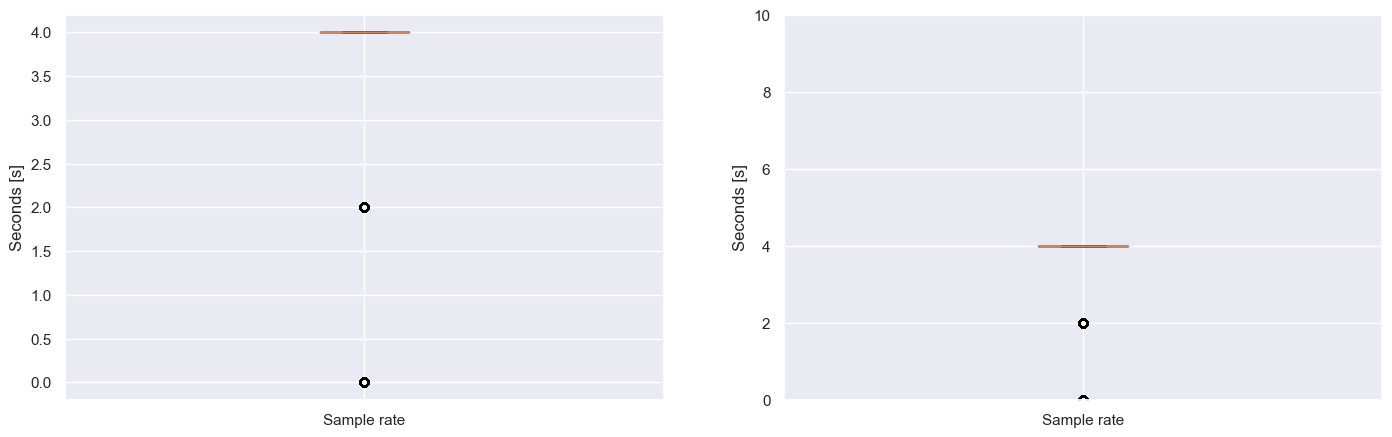

In [22]:
sample_rates = sample_rate(dataset)
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].boxplot(sample_rates, labels=["Sample rate"])
ax[0].set_ylabel("Seconds [s]")

ax[1].boxplot(sample_rates, labels=["Sample rate"])
ax[1].set_ylabel("Seconds [s]")
ax[1].set_ylim(0, 10)

In [23]:
sample_rate_summary(dataset)

Median: 4.0 | 3.979893323271011 +- 0.2187073611603137 [s]

## Numeric feature analysis
The analysis function of the ceruleo.dataset.analysis.numerical_features module provides an overview of the numeric features in the dataset. The function calculates metrics for each feature and for each run-to-failure-cycle. In the following example the result of the function is a dictionary that contains for each feature a NumericalFeaturesAnalysis object that holds for each run-to-failure-cycle the metrics computed.

IN this case we will have for the two metrics: null and std, 24 values for each metric. One metric for each run-to-failure-cycle. The null metric computes the percentage of null values in the feature and the std metric computes the standard deviation of the feature in a cycle.

In [24]:
rr = analyze(transformed_dataset, show_progress=False, what_to_compute=["null", "std"])
rr["IONGAUGEPRESSURE"]["std"]

[0.1538784215135119,
 0.16151160115580462,
 0.15799453196073904,
 0.13861749490903919,
 0.16566794042040264,
 0.16425937954116393,
 0.1703799320940931,
 0.17711007507379947,
 0.16845221328428622,
 0.1703432255813474,
 0.17112279778174258,
 0.16960183601086146,
 0.1644573963958884,
 0.1667180196658114,
 0.14469551314577048,
 0.16112822632189672,
 0.15470216323219949,
 0.19875805450944148,
 0.1573624712039302,
 0.18292432023762176,
 0.17527184147763705,
 0.1867674364630246,
 0.17406487007437757,
 0.16549787029020377]

We can compute the summary that contains the mean, standard deviation, minimum, maximum, and quantiles of the features for each run-to-failure-cycle. This summary can be used to identify patterns and anomalies in the data. In this case we have the mean value averaged over all the cycles. If a feature was not present in multiple cycles the value will tend to increase.

In [25]:
feature_summary = rr["IONGAUGEPRESSURE"].summarize()
feature_summary["null"]

MetricValuesSummary(mean=0.0, std=0.0, max=0.0, min=0.0)

It is possible finally obtain everything the summary as a DataFrame

In [26]:
analyze_as_dataframe(transformed_dataset, what_to_compute=["null", "std"])

null  \
                        Mean value across the cycles   
IONGAUGEPRESSURE                            0.000000   
ETCHBEAMVOLTAGE                             0.000000   
ETCHBEAMCURRENT                             0.000000   
ETCHSUPPRESSORVOLTAGE                       0.000000   
ETCHSUPPRESSORCURRENT                       0.000000   
FLOWCOOLFLOWRATE                            0.000000   
FLOWCOOLPRESSURE                            0.000000   
ETCHGASCHANNEL1READBACK                     0.000000   
ETCHPBNGASREADBACK                          0.000000   
FIXTURETILTANGLE                            0.000000   
ROTATIONSPEED                               0.000000   
ACTUALROTATIONANGLE                         0.000000   
FIXTURESHUTTERPOSITION                      0.000083   
ETCHSOURCEUSAGE                             0.000000   
ETCHAUXSOURCETIMER                          0.000000   
ETCHAUX2SOURCETIMER                         0.000000   
ACTUALSTEPDURATION                          0.000000   

                                                              \
                        Standard deviation across the cycles   
IONGAUGEPRESSURE                                    0.000000   
ETCHBEAMVOLTAGE                                     0.000000   
ETCHBEAMCURRENT                                     0.000000   
ETCHSUPPRESSORVOLTAGE                               0.000000   
ETCHSUPPRESSORCURRENT                               0.000000   
FLOWCOOLFLOWRATE                                    0.000000   
FLOWCOOLPRESSURE                                    0.000000   
ETCHGASCHANNEL1READBACK                             0.000000   
ETCHPBNGASREADBACK                                  0.000000   
FIXTURETILTANGLE                                    0.000000   
ROTATIONSPEED                                       0.000000   
ACTUALROTATIONANGLE                                 0.000000   
FIXTURESHUTTERPOSITION                              0.000241   
ETCHSOURCEUSAGE                                     0.000000   
ETCHAUXSOURCETIMER                                  0.000000   
ETCHAUX2SOURCETIMER                                 0.000000   
ACTUALSTEPDURATION                                  0.000000   

                                                        \
                        Maximum value found in a cycle   
IONGAUGEPRESSURE                                0.0000   
ETCHBEAMVOLTAGE                                 0.0000   
ETCHBEAMCURRENT                                 0.0000   
ETCHSUPPRESSORVOLTAGE                           0.0000   
ETCHSUPPRESSORCURRENT                           0.0000   
FLOWCOOLFLOWRATE                                0.0000   
FLOWCOOLPRESSURE                                0.0000   
ETCHGASCHANNEL1READBACK                         0.0000   
ETCHPBNGASREADBACK                              0.0000   
FIXTURETILTANGLE                                0.0000   
ROTATIONSPEED                                   0.0000   
ACTUALROTATIONANGLE                             0.0000   
FIXTURESHUTTERPOSITION                          0.0011   
ETCHSOURCEUSAGE                                 0.0000   
ETCHAUXSOURCETIMER                              0.0000   
ETCHAUX2SOURCETIMER                             0.0000   
ACTUALSTEPDURATION                              0.0000   

                                                        \
                        Minimum value found in a cycle   
IONGAUGEPRESSURE                                   0.0   
ETCHBEAMVOLTAGE                                    0.0   
ETCHBEAMCURRENT                                    0.0   
ETCHSUPPRESSORVOLTAGE                              0.0   
ETCHSUPPRESSORCURRENT                              0.0   
FLOWCOOLFLOWRATE                                   0.0   
FLOWCOOLPRESSURE                                   0.0   
ETCHGASCHANNEL1READBACK                            0.0   
ETCHPBNGASREADBACK                                 0.0   
FIXTURETILTANGLE         

## Missing values
Usually, the information of sensors is incomplete and this causes numerous missing values in the features. This library provides functions to analyse the proportion of the missing values for each feature for each life. In some cases, if the feature values are missing in multiple lives, that feature can be discarded.
We can see that FIXTURESHUTTERPOSITION has a cycle with 0.0011% of missing values, in this case we can just impute those missingvalues.

In [27]:
analyze_as_dataframe(transformed_dataset, what_to_compute=["null"])

null  \
                        Mean value across the cycles   
IONGAUGEPRESSURE                            0.000000   
ETCHBEAMVOLTAGE                             0.000000   
ETCHBEAMCURRENT                             0.000000   
ETCHSUPPRESSORVOLTAGE                       0.000000   
ETCHSUPPRESSORCURRENT                       0.000000   
FLOWCOOLFLOWRATE                            0.000000   
FLOWCOOLPRESSURE                            0.000000   
ETCHGASCHANNEL1READBACK                     0.000000   
ETCHPBNGASREADBACK                          0.000000   
FIXTURETILTANGLE                            0.000000   
ROTATIONSPEED                               0.000000   
ACTUALROTATIONANGLE                         0.000000   
FIXTURESHUTTERPOSITION                      0.000083   
ETCHSOURCEUSAGE                             0.000000   
ETCHAUXSOURCETIMER                          0.000000   
ETCHAUX2SOURCETIMER                         0.000000   
ACTUALSTEPDURATION                          0.000000   

                                                              \
                        Standard deviation across the cycles   
IONGAUGEPRESSURE                                    0.000000   
ETCHBEAMVOLTAGE                                     0.000000   
ETCHBEAMCURRENT                                     0.000000   
ETCHSUPPRESSORVOLTAGE                               0.000000   
ETCHSUPPRESSORCURRENT                               0.000000   
FLOWCOOLFLOWRATE                                    0.000000   
FLOWCOOLPRESSURE                                    0.000000   
ETCHGASCHANNEL1READBACK                             0.000000   
ETCHPBNGASREADBACK                                  0.000000   
FIXTURETILTANGLE                                    0.000000   
ROTATIONSPEED                                       0.000000   
ACTUALROTATIONANGLE                                 0.000000   
FIXTURESHUTTERPOSITION                              0.000241   
ETCHSOURCEUSAGE                                     0.000000   
ETCHAUXSOURCETIMER                                  0.000000   
ETCHAUX2SOURCETIMER                                 0.000000   
ACTUALSTEPDURATION                                  0.000000   

                                                        \
                        Maximum value found in a cycle   
IONGAUGEPRESSURE                                0.0000   
ETCHBEAMVOLTAGE                                 0.0000   
ETCHBEAMCURRENT                                 0.0000   
ETCHSUPPRESSORVOLTAGE                           0.0000   
ETCHSUPPRESSORCURRENT                           0.0000   
FLOWCOOLFLOWRATE                                0.0000   
FLOWCOOLPRESSURE                                0.0000   
ETCHGASCHANNEL1READBACK                         0.0000   
ETCHPBNGASREADBACK                              0.0000   
FIXTURETILTANGLE                                0.0000   
ROTATIONSPEED                                   0.0000   
ACTUALROTATIONANGLE                             0.0000   
FIXTURESHUTTERPOSITION                          0.0011   
ETCHSOURCEUSAGE                                 0.0000   
ETCHAUXSOURCETIMER                              0.0000   
ETCHAUX2SOURCETIMER                             0.0000   
ACTUALSTEPDURATION                              0.0000   

                                                        
                        Minimum value found in a cycle  
IONGAUGEPRESSURE                                   0.0  
ETCHBEAMVOLTAGE                                    0.0  
ETCHBEAMCURRENT                                    0.0  
ETCHSUPPRESSORVOLTAGE                              0.0  
ETCHSUPPRESSORCURRENT                              0.0  
FLOWCOOLFLOWRATE                                   0.0  
FLOWCOOLPRESSURE                                   0.0  
ETCHGASCHANNEL1READBACK                            0.0  
ETCHPBNGASREADBACK                                 0.0  
FIXTURETILTANGLE                    

We can se that there are 4 cycles with a proportion of missing values for this feature > 0, but with an small proportion.

In [28]:
rr = analyze(transformed_dataset, show_progress=False, what_to_compute=["null"])
rr["FIXTURESHUTTERPOSITION"]["null"]

[0.0,
 0.0011000495022276003,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0001789318484375671,
 0.0005336307435343965,
 0.00017414200235439987,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

## Feature standard deviation
The standard deviation of the features can be used to identify features with low variance, which may not provide useful information for predictive maintenance tasks. Features with low variance can be removed from the dataset to reduce complexity and improve model performance.

We can se that ROTATIONSPEED has a cycle with a minimum value of 0.0, this can be a problem for the model, because the feature will not provide any information for the model. 

In [29]:
analyze_as_dataframe(transformed_dataset, what_to_compute=["std"])

std  \
                        Mean value across the cycles   
IONGAUGEPRESSURE                            0.166720   
ETCHBEAMVOLTAGE                             0.380300   
ETCHBEAMCURRENT                             0.414080   
ETCHSUPPRESSORVOLTAGE                       0.557341   
ETCHSUPPRESSORCURRENT                       0.077735   
FLOWCOOLFLOWRATE                            0.412940   
FLOWCOOLPRESSURE                            0.130684   
ETCHGASCHANNEL1READBACK                     0.447334   
ETCHPBNGASREADBACK                          0.431853   
FIXTURETILTANGLE                            0.089086   
ROTATIONSPEED                               0.038895   
ACTUALROTATIONANGLE                         0.049563   
FIXTURESHUTTERPOSITION                      0.019717   
ETCHSOURCEUSAGE                             0.154297   
ETCHAUXSOURCETIMER                          0.125170   
ETCHAUX2SOURCETIMER                         0.191197   
ACTUALSTEPDURATION                          0.111877   

                                                              \
                        Standard deviation across the cycles   
IONGAUGEPRESSURE                                    0.012588   
ETCHBEAMVOLTAGE                                     0.019524   
ETCHBEAMCURRENT                                     0.020573   
ETCHSUPPRESSORVOLTAGE                               0.050995   
ETCHSUPPRESSORCURRENT                               0.005504   
FLOWCOOLFLOWRATE                                    0.035307   
FLOWCOOLPRESSURE                                    0.078748   
ETCHGASCHANNEL1READBACK                             0.027615   
ETCHPBNGASREADBACK                                  0.030993   
FIXTURETILTANGLE                                    0.023832   
ROTATIONSPEED                                       0.027090   
ACTUALROTATIONANGLE                                 0.020486   
FIXTURESHUTTERPOSITION                              0.018796   
ETCHSOURCEUSAGE                                     0.191935   
ETCHAUXSOURCETIMER                                  0.164681   
ETCHAUX2SOURCETIMER                                 0.206324   
ACTUALSTEPDURATION                                  0.042060   

                                                        \
                        Maximum value found in a cycle   
IONGAUGEPRESSURE                              0.198758   
ETCHBEAMVOLTAGE                               0.409515   
ETCHBEAMCURRENT                               0.441704   
ETCHSUPPRESSORVOLTAGE                         0.716162   
ETCHSUPPRESSORCURRENT                         0.088157   
FLOWCOOLFLOWRATE                              0.503905   
FLOWCOOLPRESSURE                              0.401497   
ETCHGASCHANNEL1READBACK                       0.516869   
ETCHPBNGASREADBACK                            0.513432   
FIXTURETILTANGLE                              0.148195   
ROTATIONSPEED                                 0.085676   
ACTUALROTATIONANGLE                           0.087564   
FIXTURESHUTTERPOSITION                        0.057795   
ETCHSOURCEUSAGE                               0.732096   
ETCHAUXSOURCETIMER                            0.495712   
ETCHAUX2SOURCETIMER                           0.620918   
ACTUALSTEPDURATION                            0.192831   

                                                        
                        Minimum value found in a cycle  
IONGAUGEPRESSURE                          1.386175e-01  
ETCHBEAMVOLTAGE                           3.239813e-01  
ETCHBEAMCURRENT                           3.509712e-01  
ETCHSUPPRESSORVOLTAGE                     4.599301e-01  
ETCHSUPPRESSORCURRENT                     6.658743e-02  
FLOWCOOLFLOWRATE                          3.417936e-01  
FLOWCOOLPRESSURE                          8.276058e-02  
ETCHGASCHANNEL1READBACK                   3.771744e-01  
ETCHPBNGASREADBACK                        3.650782e-01  
FIXTURETILTANGLE                     

We can se that there are a lot of cycles with a low variance

In [30]:
rr = analyze(transformed_dataset, show_progress=False, what_to_compute=["std"])
rr["ROTATIONSPEED"]["std"]

[0.0195906016364457,
 0.04336851470681955,
 0.05799620898185587,
 1.1102230246251565e-16,
 0.0360890061340275,
 0.038201237893065954,
 1.1102230246251565e-16,
 0.06606608560204476,
 0.04426971331940611,
 0.06907071252869629,
 0.08567629006783237,
 0.05527193794092481,
 0.048860280663576686,
 0.048314164539748315,
 0.0630512429349472,
 0.038968725642062135,
 0.06539096888505944,
 0.07326999721034945,
 0.01789179320551508,
 5.551115123125783e-17,
 1.1102230246251565e-16,
 0.0,
 5.551115123125783e-17,
 0.06212923988601241]

If we inspect these cycles we can se that, in fact, this feature has a constant value.

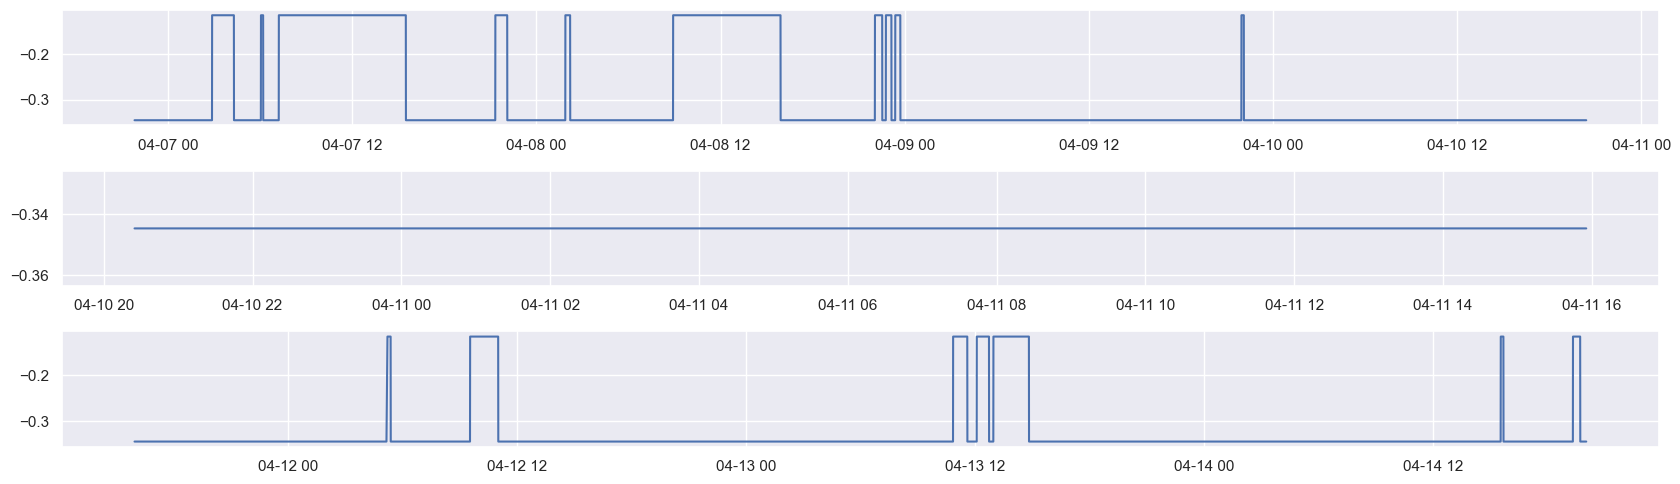

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(17, 5))
ax[0].plot(transformed_dataset[2][0]["ROTATIONSPEED"])
ax[1].plot(transformed_dataset[3][0]["ROTATIONSPEED"])
ax[2].plot(transformed_dataset[4][0]["ROTATIONSPEED"])
fig.tight_layout()

## monotonicity
The monotonicity of the features can be used to identify features that exhibit a consistent trend over time. Monotonic features can provide valuable information for predictive maintenance tasks, as they capture the gradual degradation of equipment.

We can see that that the timers are monotonic, this is expected, because the time is always increasing. And then the ETCHSOURCEUSAGE it's also monotonic, this is also expected, because the etch source usage is always increasing. In this case the presence of multiple correlated monotonic features can be a sign of multicollinearity, which can affect the performance of predictive models. 



In [32]:
analyze_as_dataframe(transformed_dataset, what_to_compute=["monotonicity"]).sort_values(
    by=("monotonicity", "Mean value across the cycles"), ascending=False
)

monotonicity  \
                        Mean value across the cycles   
ETCHAUXSOURCETIMER                          0.629001   
ETCHAUX2SOURCETIMER                         0.628923   
ETCHSOURCEUSAGE                             0.591408   
IONGAUGEPRESSURE                            0.131580   
ETCHBEAMCURRENT                             0.079963   
ETCHSUPPRESSORVOLTAGE                       0.049960   
FLOWCOOLPRESSURE                            0.036722   
ETCHSUPPRESSORCURRENT                       0.027669   
ETCHPBNGASREADBACK                          0.010919   
FLOWCOOLFLOWRATE                            0.008001   
ETCHGASCHANNEL1READBACK                     0.007628   
ETCHBEAMVOLTAGE                             0.004334   
FIXTURETILTANGLE                            0.000713   
ACTUALROTATIONANGLE                         0.000430   
ACTUALSTEPDURATION                          0.000287   
FIXTURESHUTTERPOSITION                      0.000087   
ROTATIONSPEED                               0.000005   

                                                              \
                        Standard deviation across the cycles   
ETCHAUXSOURCETIMER                                  0.081907   
ETCHAUX2SOURCETIMER                                 0.081898   
ETCHSOURCEUSAGE                                     0.108967   
IONGAUGEPRESSURE                                    0.037162   
ETCHBEAMCURRENT                                     0.022276   
ETCHSUPPRESSORVOLTAGE                               0.021527   
FLOWCOOLPRESSURE                                    0.060791   
ETCHSUPPRESSORCURRENT                               0.016906   
ETCHPBNGASREADBACK                                  0.006596   
FLOWCOOLFLOWRATE                                    0.003239   
ETCHGASCHANNEL1READBACK                             0.004352   
ETCHBEAMVOLTAGE                                     0.005614   
FIXTURETILTANGLE                                    0.000339   
ACTUALROTATIONANGLE                                 0.001567   
ACTUALSTEPDURATION                                  0.000339   
FIXTURESHUTTERPOSITION                              0.000067   
ROTATIONSPEED                                       0.000021   

                                                        \
                        Maximum value found in a cycle   
ETCHAUXSOURCETIMER                            0.767106   
ETCHAUX2SOURCETIMER                           0.766641   
ETCHSOURCEUSAGE                               0.781429   
IONGAUGEPRESSURE                              0.246032   
ETCHBEAMCURRENT                               0.122318   
ETCHSUPPRESSORVOLTAGE                         0.119048   
FLOWCOOLPRESSURE                              0.317460   
ETCHSUPPRESSORCURRENT                         0.085868   
ETCHPBNGASREADBACK                            0.025808   
FLOWCOOLFLOWRATE                              0.014125   
ETCHGASCHANNEL1READBACK                       0.023810   
ETCHBEAMVOLTAGE                               0.023810   
FIXTURETILTANGLE                              0.001484   
ACTUALROTATIONANGLE                           0.007937   
ACTUALSTEPDURATION                            0.001789   
FIXTURESHUTTERPOSITION                        0.000194   
ROTATIONSPEED                                 0.000108   

                                                        
                        Minimum value found in a cycle  
ETCHAUXSOURCETIMER                            0.420611  
ETCHAUX2SOURCETIMER                           0.420611  
ETCHSOURCEUSAGE                               0.325093  
IONGAUGEPRESSURE                              0.081020  
ETCHBEAMCURRENT                               0.039683  
ETCHSUPPRESSORVOLTAGE                         0.021107  
FLOWCOOLPRESSURE                              0.001423  
ETCHSUPPRESSORCURRENT                         0.000000  
ETCHPBNGASREADBACK                            0.005138  
FLOWCOOLFLOWRATE            

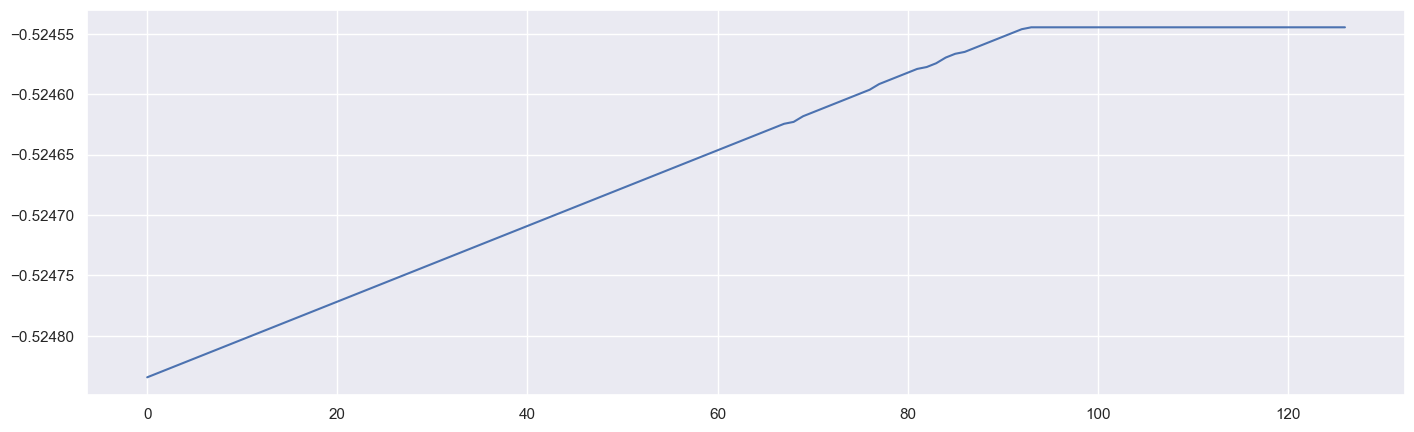

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(transformed_dataset[-4][0]["ETCHSOURCEUSAGE"].values)

## Relation with the target
The relation between the features and the target variable can be analyzed using correlation coefficients. The correlation analysis can help identify features that are strongly related to the target variable and can be used to build predictive models.

We can see that only the timers and usage are highly correlated with the target variable. This is expected because the target variable is the RUL and the timers and usage are the only features that are related to the time. The othrs features are not strongly correlated with the target variable.

In [34]:
analyze_as_dataframe(transformed_dataset, what_to_compute=["correlation"]).sort_values(
    by=("correlation", "Mean value across the cycles"), ascending=False
)

correlation  \
                        Mean value across the cycles   
ETCHAUXSOURCETIMER                          0.844595   
ETCHSOURCEUSAGE                             0.783816   
ETCHAUX2SOURCETIMER                         0.743158   
FLOWCOOLPRESSURE                            0.034503   
ACTUALSTEPDURATION                          0.015444   
FIXTURETILTANGLE                            0.003311   
ETCHGASCHANNEL1READBACK                    -0.010918   
ETCHBEAMCURRENT                            -0.011158   
ROTATIONSPEED                              -0.013429   
ACTUALROTATIONANGLE                        -0.024491   
FLOWCOOLFLOWRATE                           -0.025738   
ETCHSUPPRESSORVOLTAGE                      -0.028417   
ETCHBEAMVOLTAGE                            -0.029537   
FIXTURESHUTTERPOSITION                     -0.032806   
IONGAUGEPRESSURE                           -0.036029   
ETCHSUPPRESSORCURRENT                      -0.040677   
ETCHPBNGASREADBACK                         -0.045505   

                                                              \
                        Standard deviation across the cycles   
ETCHAUXSOURCETIMER                                  0.371078   
ETCHSOURCEUSAGE                                     0.437367   
ETCHAUX2SOURCETIMER                                 0.469988   
FLOWCOOLPRESSURE                                    0.305846   
ACTUALSTEPDURATION                                  0.183581   
FIXTURETILTANGLE                                    0.122210   
ETCHGASCHANNEL1READBACK                             0.202759   
ETCHBEAMCURRENT                                     0.209831   
ROTATIONSPEED                                       0.074998   
ACTUALROTATIONANGLE                                 0.271434   
FLOWCOOLFLOWRATE                                    0.209273   
ETCHSUPPRESSORVOLTAGE                               0.236531   
ETCHBEAMVOLTAGE                                     0.226633   
FIXTURESHUTTERPOSITION                              0.199978   
IONGAUGEPRESSURE                                    0.276078   
ETCHSUPPRESSORCURRENT                               0.216098   
ETCHPBNGASREADBACK                                  0.206210   

                                                        \
                        Maximum value found in a cycle   
ETCHAUXSOURCETIMER                            1.000000   
ETCHSOURCEUSAGE                               0.999995   
ETCHAUX2SOURCETIMER                           1.000000   
FLOWCOOLPRESSURE                              0.603682   
ACTUALSTEPDURATION                            0.412032   
FIXTURETILTANGLE                              0.318482   
ETCHGASCHANNEL1READBACK                       0.307965   
ETCHBEAMCURRENT                               0.419246   
ROTATIONSPEED                                 0.118146   
ACTUALROTATIONANGLE                           0.751982   
FLOWCOOLFLOWRATE                              0.352479   
ETCHSUPPRESSORVOLTAGE                         0.407153   
ETCHBEAMVOLTAGE                               0.475763   
FIXTURESHUTTERPOSITION                        0.295252   
IONGAUGEPRESSURE                              0.562739   
ETCHSUPPRESSORCURRENT                         0.275416   
ETCHPBNGASREADBACK                            0.268059   

                                                        
                        Minimum value found in a cycle  
ETCHAUXSOURCETIMER                           -0.264857  
ETCHSOURCEUSAGE                              -0.432908  
ETCHAUX2SOURCETIMER                          -0.432908  
FLOWCOOLPRESSURE                             -0.916936  
ACTUALSTEPDURATION                           -0.459476  
FIXTURETILTANGLE                             -0.223626  
ETCHGASCHANNEL1READBACK                      -0.688285  
ETCHBEAMCURRENT                              -0.606570  
ROTATIONSPEED                                -0.187191  
ACTUALROTATIONANGLE          

## Feature pairwise correlation

The pairwise correlation between features can be used to identify relationships between variables and detect multicollinearity. Multicollinearity occurs when two or more features are highly correlated, which can lead to unstable model coefficients and inaccurate predictions.

We can see that ETCHGASCHANNEL1READBACK and ETCHPBNGASREADBACK are highly correlated. This is expected because these features are related to the same process. 

Another example is ETCHBEAMCURRENT and ETCHSUPPRESSORCURRENT.


In [35]:
from ceruleo.dataset.analysis.correlation import correlation_analysis

In [36]:
(
    correlation_analysis(transformed_dataset)
    .to_pandas()
    .sort_values(by="abs_mean_correlation", ascending=False)
    .head(15)
)

,feature_1,feature_2,mean_correlation,std_correlation,max_correlation,min_correlation,abs_mean_correlation,std_abs_mean_correlation
81,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,0.974040,0.015899,0.998851,0.909530,0.974040,0.015899
62,ETCHBEAMCURRENT,ETCHSUPPRESSORCURRENT,0.969555,0.017441,0.999941,0.926967,0.969555,0.017441
73,ETCHBEAMVOLTAGE,ETCHSUPPRESSORCURRENT,0.961725,0.019763,0.999911,0.907479,0.961725,0.019763
89,ETCHGASCHANNEL1READBACK,IONGAUGEPRESSURE,0.961469,0.012155,0.983084,0.935980,0.961469,0.012155
58,ETCHBEAMCURRENT,ETCHBEAMVOLTAGE,0.961391,0.018625,0.999966,0.896134,0.961391,0.018625
98,ETCHPBNGASREADBACK,IONGAUGEPRESSURE,0.951679,0.033223,0.987659,0.807029,0.951679,0.033223
31,ETCHAUX2SOURCETIMER,ETCHAUXSOURCETIMER,0.833866,0.481966,1.000000,-0.772497,0.951071,0.118294
96,ETCHPBNGASREADBACK,FLOWCOOLFLOWRATE,0.933385,0.020826,0.991879,0.885555,0.933385,0.020826
87,ETCHGASCHANNEL1READBACK,FLOWCOOLFLOWRATE,0.914023,0.027393,0.996820,0.867820,0.914023,0.027393
68,ETCHBEAMCURRENT,IONGAUGEPRESSURE,0.903116,0.023172,0.970433,0.873936,0.903116,0.023172


### ETCHBEAMCURRENT and ETCHSUPPRESSORCURRENT are highly correlated

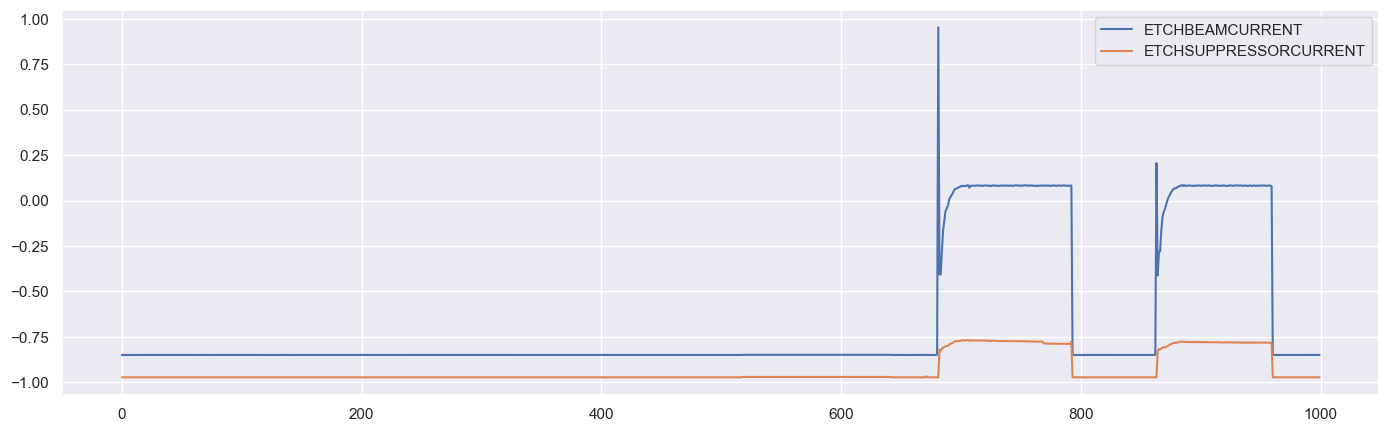

In [37]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(transformed_dataset.get_features_of_life(12)['ETCHBEAMCURRENT'].values[-1000:],
        label='ETCHBEAMCURRENT')
ax.plot(transformed_dataset.get_features_of_life(12)['ETCHSUPPRESSORCURRENT'].values[-1000:], 
        label='ETCHSUPPRESSORCURRENT')
ax.legend()

## Feature distribution

The distribution of feature values can provide insights into the data's behavior and identify any anomalies or biases. Understanding the distribution of features is crucial for building accurate predictive models and making informed decisions.
ALso if there are distribution values difference accross cycles may indicate different operating conditions or equipment states that may affect the predictive model's performance.

We are going to compare cycles with similar length to avoid problems when computing the distribution values.
We can see that the top offenders present different distribution that may indicate a change in the operating conditions.

In [43]:
from ceruleo.dataset.analysis.distribution import features_divergeces

In [100]:
d = features_divergeces(transformed_dataset, number_of_bins=5)
# Keep cycles with length > 1000
d = d[ (d["Cycle 1 length"] > 1000) & (d["Cycle 2 length"] > 1000)]
# Keep Pairs of cycles with similar length
d = d[d["Abs Length difference"] < 1000]

In [120]:
d.sort_values(by=[ "KL", "Abs Length difference",], ascending=[False, True]).head(15)

,Cycle 1,Cycle 2,Cycle 1 length,Cycle 2 length,Abs Length difference,Wasserstein,KL,feature
615,2,21,22801,22588,213,0.000000,23.025851,ETCHAUX2SOURCETIMER
891,2,21,22801,22588,213,0.000000,23.025851,ETCHAUXSOURCETIMER
689,6,21,21591,22588,997,0.000000,23.025851,ETCHAUX2SOURCETIMER
2345,6,21,21591,22588,997,0.000000,23.025851,ETCHSOURCEUSAGE
965,6,21,21591,22588,997,0.028845,10.919734,ETCHAUXSOURCETIMER
1995,2,21,22801,22588,213,0.037269,0.895635,ETCHPBNGASREADBACK
4479,2,21,22801,22588,213,0.027420,0.771321,ROTATIONSPEED
2069,6,21,21591,22588,997,0.005030,0.686197,ETCHPBNGASREADBACK
63,2,21,22801,22588,213,0.018315,0.513243,ACTUALROTATIONANGLE
339,2,21,22801,22588,213,0.013813,0.386058,ACTUALSTEPDURATION


In [114]:
def plot_distributions(ax, ds, life1, life2, feature, bins=10):
    ax.hist(
        ds.get_features_of_life(life1)[feature],
        label=feature,
        density=True,
        alpha=0.8,
        bins=bins,
    )
    ax.hist(
        ds.get_features_of_life(life2)[feature],
        label=feature,
        density=True,
        alpha=0.8,
        bins=bins,
    )
    ax.legend()


def plot_timeseries(ax, ds, life, feature):
    ax.plot(ds.get_features_of_life(life)[feature].values, alpha=0.5, label=feature)

### KL Divergence

In this case if we see the top offenders, we can see tha tha timers are in the top. Probably because at the start of the cycles the usage or timers were at diffeernt values. The differnece is between the cycles 2 and 21, and 6 and 21
We can also see  that ETCHPBNGASREADBACK present a bias in the values

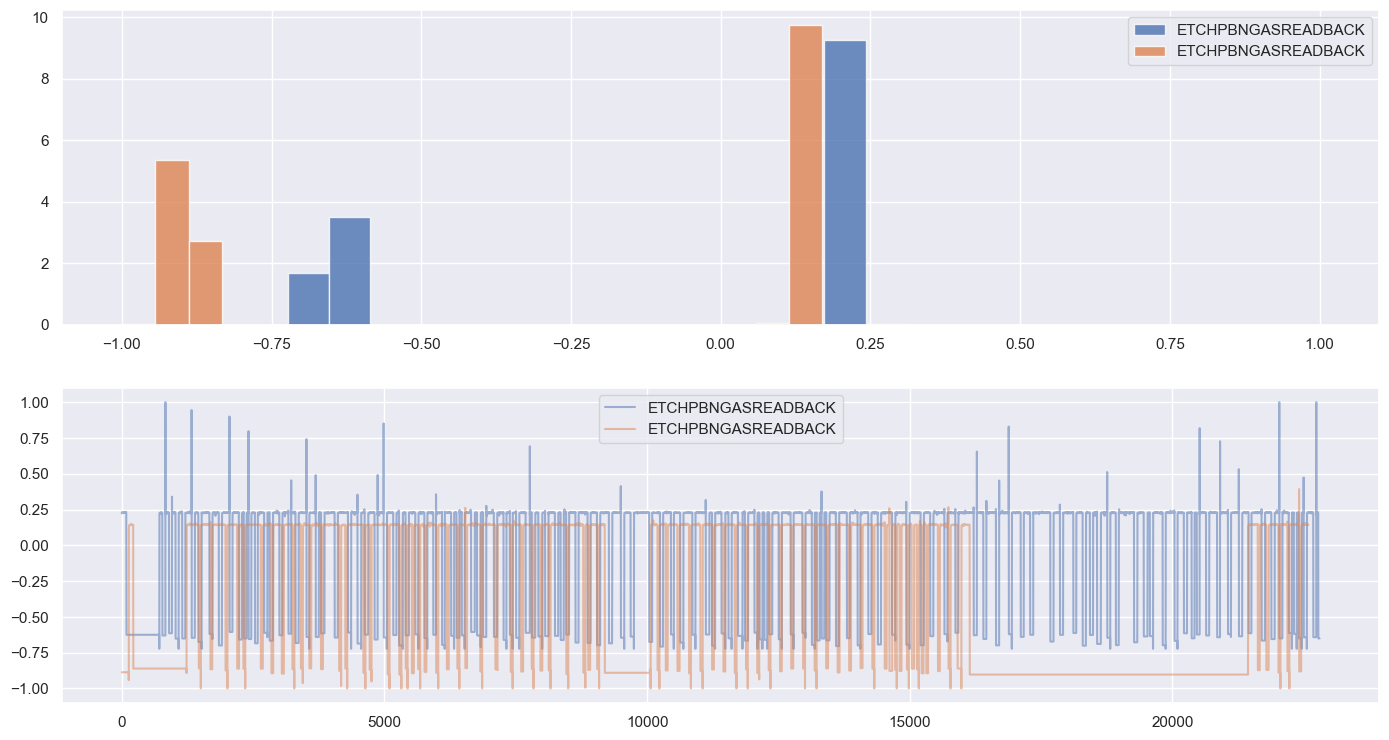

In [116]:
first_row = d.sort_values(by=[ "KL", "Abs Length difference",], ascending=[False, True]).iloc[5, :]
feature = first_row["feature"]
life1 = first_row["Cycle 1"]
life2 = first_row["Cycle 2"]
fig, ax = plt.subplots(2, 1, figsize=(17, 9))
plot_distributions(ax[0], transformed_dataset, life1, life2, feature, bins=25)

plot_timeseries(ax[1], transformed_dataset, life1, feature)
plot_timeseries(ax[1], transformed_dataset, life2, feature)
ax[1].legend()




### Wasserstein

We can also see  that ETCHBEAMVoltage present a bias in the values

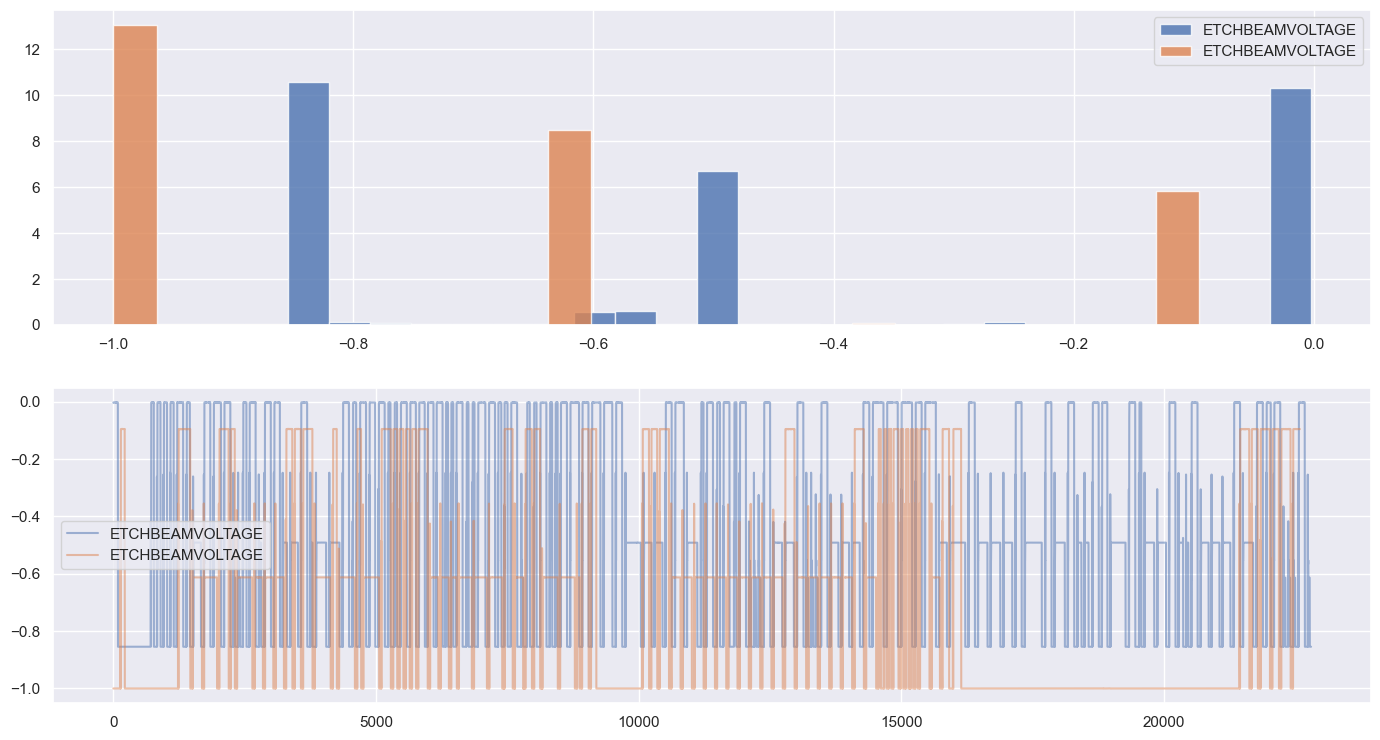

In [119]:
fig, ax = plt.subplots(2, 1, figsize=(17, 9))
first_row = d.sort_values(by=[ "Wasserstein", "Abs Length difference",], ascending=[False, True]).iloc[0, :]
feature = first_row["feature"]
life1 = first_row["Cycle 1"]
life2 = first_row["Cycle 2"]
plot_distributions(ax[0], transformed_dataset, life1, life2, feature, bins=25)


plot_timeseries(ax[1], transformed_dataset, life1, feature)
plot_timeseries(ax[1], transformed_dataset, life2, feature)
ax[1].legend()